In [1]:
#%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

# import functions as fc
import harmonica as hm

In [2]:
# Model`s limits
xmin, xmax = 0.0, 1e5 #100km
zmin, zmax = 0.0, 4e4 #40km
ymin, ymax = -1e6, 1e6 #2000km
area = [xmin, xmax, zmin, zmax]

nx = 200 
x = np.linspace(xmin, xmax, nx)
y = np.zeros_like(x)
z = np.zeros_like(x)

dx = x[1] - x[0] #(ymax - ymin)/ny
# sigma = 2.0
# edge = sigma*dx*nx

# Densidades

In [3]:
def rand(limits):
    return np.random.uniform(limits[0], limits[1])

def rand_densities(dw=1030,
                   ds_up=(2500,2800),
                   ds_bottom=(2150,2800),
                   dcc=(2800,3000),
                   doc=(3000,3200),
                   dm=(3400,4400)):
    #get every density and it range
    kwargs = locals()

    ans = dict()
    for layer, dens in kwargs.items():
        if isinstance(dens, tuple):
            ans[layer] = rand(dens)
        else:
            ans[layer] = dens

    # return ans
    ans_list = []
    for d in ['dw', 'ds_up', 'ds_bottom', 'dcc', 'dm']:
        ans_list.append(ans[d])
    return ans_list

def fixed_densities():
    return [1030, 2700, 2150, 3000, 3800]

# S0 = np.array([29500.0])
# dS0 = np.array([1500.0])
# COT = 117000.0 #transição da continental para a oceanica

# Geometrias

In [4]:
def flat_surfaces(x, zmax, amp=0.1, hfreq_amp=0.5, hfreq=3, limit=None, T=(0,0.5), offset_x=(0,np.pi/2), offset_height=(-0.1,0.1), high_freq=True,
                  preset=None):
    
    T_x = x[-1] - x[0]
    if preset == 'bath':
        amp, T = 0.08, (0,0.5)
        hfreq_amp, hfreq = 0.5, 2.5
        offset_x, offset_height = (-np.pi/2, np.pi/2), (0.005, 0.03)
        high_freq = True    
    elif preset == 'sed':
        amp, T = 0.08, (0,0.7)
        hfreq_amp, hfreq = 0.4, 3.5
        offset_x, offset_height = (-np.pi/2,np.pi/2), (0.04, 0.07)
        high_freq = True    

    T, offset_x, offset_height = rand(T), rand(offset_x), rand(offset_height)
    surface = zmax * amp * np.sin(T*2*np.pi*x/T_x + offset_x) + zmax*offset_height
    if high_freq:
        surface += hfreq_amp*zmax * (amp * np.sin(hfreq*T*2*np.pi*x/T_x + offset_x))
    
    
    if limit is not None:
        surface += limit
        surface[surface < limit] = limit[surface < limit]
    surface[surface<0] = 0

    return surface

def noise_surface(x, zmax, min_thick=None, limit=None, freq=[1,2,3,5], amp=[0.1, 0.05, 0.03, 0.01], offset_height=(0.05,0.2)):
    T_x = x[-1] - x[0]
    surface = np.zeros_like(x)
    surface += zmax * rand(offset_height)
    for i, f in enumerate(freq):
        f_real = rand((0,f))
        offset_x = rand((-np.pi/2, np.pi/2))
        surface += zmax * amp[i] * np.sin(f_real*2*np.pi*x/T_x + offset_x) * np.random.choice([-1,1])

    SAMPLE_SIZE = 30
    random_indices = np.random.choice(surface.shape[0], size=SAMPLE_SIZE, replace=False)
    if 0 not in random_indices:
        random_indices = np.append(random_indices, 0)
    if surface.shape[0] - 1 not in random_indices:
        random_indices = np.append(random_indices, surface.shape[0] - 1)
    random_indices.sort()
    surface = np.interp(x, x[random_indices], surface[random_indices])

    if min_thick is not None:
        surface[(surface-limit) < min_thick] = min_thick + limit[(surface-limit) < min_thick]
    elif limit is not None:
        surface += limit        
        surface[surface < limit] = limit[surface < limit]
        
    return surface
  

In [5]:
def make_layers():
    zero = np.zeros_like(x)
    w = flat_surfaces(x, zmax, preset='bath')
    s1 = flat_surfaces(x, zmax, limit=w, preset='sed')
    base = noise_surface(x, zmax, limit=s1)
    moho = noise_surface(x, zmax, limit=base, min_thick=5000, offset_height=(0.3,0.7))
    end = np.zeros_like(x) + zmax 
    return [zero, w, s1, base, moho, end]
# layers = make_layers()
# zero, w, s1, base, moho, end = layers

def plot_surfaces(x, zmax, surfaces, colors=['black', 'b', 'brown', 'orange', 'red']):
    _, ax = plt.subplots()

    for i, surface in enumerate(surfaces):
        ax.plot(x, surface, c=colors[i])
    ax.set(xlim=(0, x[-1]), ylim=(zmax, -1000))
# plot_surfaces(x, zmax, [zero, w, s1, base, moho])

# Make Prisms

In [6]:
#Prismas
def make_prism(x, y, z, z_previous, dx):
    n = len(x)
    prism = []
    for i, (x_i, z_i, z_p) in enumerate(zip(x, z, z_previous)):
        if i==0 or i==n-1:
            ddx = dx*n*0.03  #Correção do efeito de borda
        else:
            ddx = dx
        prism.append([x_i-ddx/2, x_i+ddx/2, y[0], y[1], z_p, z_i])
    return prism

#Todos os prismas
def make_prisms(layers):
    all_prism = []
    for i, _ in enumerate(layers[1:]):
        all_prism.append(make_prism(x, (ymin, ymax), layers[i+1], layers[i], dx))
    return all_prism

# Visualização

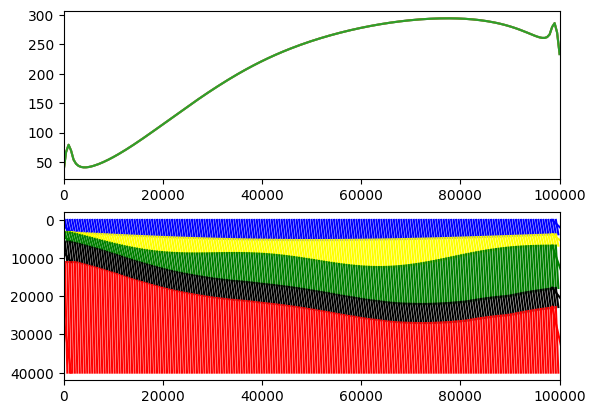

In [7]:
#Disturbio de Gravimetria
def calc_grav(coordinates, prisms, densities):
    gsyn = np.zeros_like(coordinates)
    densities =  rand_densities() 
    for i, coord in enumerate(coordinates):
        for j, prism in enumerate(prisms):
            d = np.zeros(len(prism)) + densities[j] - densities[3]  #Compensar a densidade da plataforma continental
            gsyn[i] += hm.prism_gravity(coord, prism, d, field='g_z')
    return gsyn

#Visualização
def view_prism(all_prism, gsyn, show=True):
    fig, ax = plt.subplots(nrows=2)
    colors = ['b', 'yellow', 'g', 'black', 'red']
    for i, prism in enumerate(all_prism):
        for p in prism:
            ax[1].plot([p[0], p[1]], [p[4], p[5]], c=colors[i])
    ax[1].invert_yaxis()
    ax[0].set(xlim=(0,100000))
    ax[1].set(xlim=(0,100000))
    _ = ax[0].plot(x, gsyn)
    if show:
        plt.show()
    return fig

#Coordenadas
coordinates = []
y_m, z_m = 0, -150 #-150 é a altura do satelite para medição
for xi in x:
    coordinates.append((xi, y_m, z_m))

#EXEMPLO
layers = make_layers()
all_prism = make_prisms(layers)
# densities = rand_densities()
densities = fixed_densities()
gsyn = calc_grav(coordinates, all_prism, densities)
fig = view_prism(all_prism, gsyn, False)

In [8]:
def make_dataset(density='fixed'):
    layers = make_layers()
    all_prism = make_prisms(layers)

    if density == 'fixed':
        densities = fixed_densities()
    else:
        densities = rand_densities()
        
    gsyn = calc_grav(coordinates, all_prism, densities)
    return layers, gsyn, all_prism

def save_dataset(path, data, i, fig=None, folder_type='train', **kwargs):
    #Save data
    filename = path + f"series/{folder_type}/dado_{i+1}.csv"
    np.savetxt(filename, data, delimiter=",")
    
    #Save figure
    filename = path + f"images/img_{i+1}.png"
    if fig is not None:
        fig.savefig(filename)

    #Save params
    if kwargs:
        filename = path + f"parametros_{i+1}.txt"
        with open(filename, 'w') as f:
            for key, value in kwargs.items():
                f.write(f"{key}: {value}\n")

### Create data directory

In [10]:
folders = [
    "data",
    "data/images",
    "data/params",
    "data/series",
    "data/series/train",
    "data/series/test"
]

# Create folders if they don't exist
def create_dir(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

for folder in folders:
    create_dir(folder)

### Clear Folders to repeat data creation

In [11]:
def clear_folder(folder_path):
    
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            os.remove(file_path)

root_path = "data/"
folders = ['images', 'series/test', 'series/train', 'params']
for fold in folders:
    clear_folder(root_path + fold)

### Generate Synthetic data

In [12]:
""" 
Estrutura de pastas:
                ../data
                    |series
                        |train
                        |test
                    |images
                    |params
"""

plt.ioff()
n_dados = 10
path = "data/"

filename = path + "params/header.csv"
save_labels = ['x', 'g', 'sea_zero_lv', 'bath', 'ts', 't_base', 't_moho', 'm_lv']
np.savetxt(filename, save_labels, delimiter=",", fmt="%s")

train_split = 0.8
for i in range(n_dados):
    save_params = {"layers_dens": ['tw', 'ts1', 'ts2', 'tc', 'tm'],
                "densidade": fixed_densities(),
                #"densidade" = rand_densities(),
                "z_range": (zmin, zmax),
                "y_range": (ymin, ymax),
                "nx_prism_columns": nx,
                "dx": dx}
    
    layers, gsyn, all_prism = make_dataset()
    fig = view_prism(all_prism, gsyn, show=False)
    data = np.concatenate([ x[:, np.newaxis], gsyn[:,0][:, np.newaxis], np.asarray(layers).T ], axis=1)
    
    if i< train_split*n_dados:
        ftype = 'train'
    else:
        ftype = 'test'
    # save_dataset(path, data, i, **save_params)
    save_dataset(path, data, i, folder_type=ftype, fig=fig)  


### Create new csv with merged data inside folder

In [13]:
def merge_csv_files(folder_path, labels):
    dfs = []
    
    # Iterate over all files in the folder
    for filename in os.listdir(folder_path):
        if filename.startswith('merged_data'):
            continue
        
        file_path = os.path.join(folder_path, filename)
        if filename.endswith('.csv'):
            df = pd.read_csv(file_path, header=None, names=labels)
            df['File'] = filename.split('.')[0]
            dfs.append(df)
    
    merged_df = pd.concat(dfs, ignore_index=True)
    merged_df.to_csv(f'{folder_path}/merged_data.csv', index=False)
    return merged_df

folder_path = ["data/series/train", "data/series/test"]
labels = ['x', 'g', 'sea_zero_lv', 'bath', 'ts', 't_base', 't_moho', 'm_lv']
for fold in folder_path:
    _ = merge_csv_files(fold, labels)